## Importations et chargement

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
csv_path = 'data/CES19.csv'


In [28]:
df = pd.read_csv(csv_path, index_col=0)
df.head()

df_columns = df.columns

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (25,27,28,30,31,33,34,39,179,181,188,192,193,199,210,227,234,236,237,239,240,243,276,299,302,311,314,315,316,327,362,417,418,421,422,423,424,425,431,464,465,468,538,541,578,579,582,583,584) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [71]:
def get_column_names():
    """
    Returns a list of column names
    """
    return df.columns.tolist()

def get_column_value_counts(column_name):
    """
    Returns a df with the value counts of a column
    """
    return df[column_name].value_counts()

def plot_column_values(column_name):
    """
    Plots a column values
    """
    df[column_name].value_counts().plot(kind='bar')
    plt.title(f"Distribution des réponses de la question {column_name}")
    plt.show()

def get_unique_values_per_column(min_unique_threshold=None, max_unique_threshold=None):
    """
    Returns a list of unique values per column with optional minimum threshold
    """
    unique_values = df.nunique()

    if min_unique_threshold:
        unique_values = unique_values[unique_values > min_unique_threshold]
    elif max_unique_threshold:
        unique_values = unique_values[unique_values < max_unique_threshold]

    return unique_values

def get_columns_per_value_keyword(keyword):
    """
    Returns a list of columns with a value containing the keyword
    """
    return df.columns[df.apply(lambda x: keyword in x.values, axis=0)].tolist()

def get_samples_per_column(N=5):
    """
    Returns a sample of non-NaN answers per column if they exist
    """
    samples_per_column = {}
    for column in df.columns:
        non_nan_values = df[column][~df[column].isna()]

        if len(non_nan_values) > N:
            samples_per_column[column] = non_nan_values.sample(N).tolist()

    return samples_per_column
    

In [88]:
samples_per_column = get_samples_per_column()

samples_per_column

{'cps19_StartDate': ['2019-10-14 07:27:14',
  '2019-09-22 22:16:35',
  '2019-10-04 06:18:41',
  '2019-10-17 07:03:12',
  '2019-09-13 11:19:15'],
 'cps19_EndDate': ['2019-10-08 04:35:35',
  '2019-09-22 15:19:37',
  '2019-09-28 06:57:04',
  '2019-09-13 11:45:32',
  '2019-10-05 09:32:57'],
 'cps19_ResponseId': ['R_1eJksRCoed26AhZ',
  'R_PLFJozJJSuSPYe5',
  'R_OBjkpUJo7K2g7M5',
  'R_3noTAxB1dKP1kBA',
  'R_5dmLqVCPHHFf0GZ'],
 'cps19_consent': ['I consent to participate in this study. I have read all of the information about the study.',
  'I consent to participate in this study. I have read all of the information about the study.',
  'I consent to participate in this study. I have read all of the information about the study.',
  'I consent to participate in this study. I have read all of the information about the study.',
  'I consent to participate in this study. I have read all of the information about the study.'],
 'cps19_citizenship': ['Permanent resident',
  'Canadian citizen',
  'Can

### Enlever les colonnes ayant plus de 125 réponses uniques

In [34]:
unique_answers_max = 125
columns_with_too_many_unique_answers = get_unique_values_per_column(min_unique_threshold=unique_answers_max)

print(f"\nIl y a {len(columns_with_too_many_unique_answers)} colonnes avec trop de réponses uniques.\n")

# Create another df without those columns
df2 = df.loc[:, [column not in columns_with_too_many_unique_answers for column in df.columns]]


Il y a 47 colonnes avec trop de réponses uniques.



### Enlever les colonnes ayant 0 ou 1 réponse unique

In [35]:
unique_answers_min = 2
columns_without_enough_unique_answers = get_unique_values_per_column(max_unique_threshold=unique_answers_min)

print(f"\nIl y a {len(columns_without_enough_unique_answers)} colonnes avec trop peu de réponses uniques.\n")

# Create another df without those columns
df3 = df2.loc[:, [column not in columns_without_enough_unique_answers for column in df2.columns]]


Il y a 137 colonnes avec trop peu de réponses uniques.



### Enlever les questions jugées non-pertinentes

In [36]:
non_pertinent_columns = [
    "cps19_consent", # La question de consentement à répondre avant de commencer le questionnaire
    
]

print(f"\nIl y a {len(non_pertinent_columns)} colonnes non pertinentes.\n")

df4 = df3.loc[:, [column not in non_pertinent_columns for column in df3.columns]]

df4


Il y a 1 colonnes non pertinentes.



### Trouver les questions à choix multiples non étalées sur plusieurs questions

In [147]:
multiple_choice_question_keywords = ["Very satisfied", "None of these", "Got better", "Fewer immigrants", "Fewer refugees", "Not at all well", "Very opposed", "Fairly strongly", "Some of the time", "Much closer", "A good job", "None at all", "Very comfortable", "Extremely easy", "Weekly", "Sometimes", "Just once", "Much more"]
#print(get_columns_per_value_keyword("Very satisfied"))

# Questions à 7 choix
six_choice_questions = ['pes10_socnet3']
print(f"Il y a {len(six_choice_questions)} questions à 7 choix.")

# Questions à 6 choix
six_choice_questions = ['pes19_keepromises', 'pes19_tieus', 'pes19_tiechina', 'pes19_emb_info', 'pes19_donerm', 'pes19_donew', 'pes19_donegl', 'pes19_doneqc', 'pes19_taxes_1', 'pes19_taxes_2', 'pes19_taxes_3', 'pes19_taxes_4', 'pes19_taxes_5', 'pes19_gap']
print(f"Il y a {len(six_choice_questions)} questions à 6 choix.")

# Questions à 5 choix
five_choice_questions = ['cps19_demsat', 'cps19_fed_gov_sat', 'cps19_prov_gov_sat', 'pes19_dem_sat', 'pes19_emb_satif', "cps19_rel_imp", 'cps19_pos_fptp', 'cps19_pos_life', 'cps19_pos_cannabis', 'cps19_pos_carbon', 'cps19_pos_energy', 'cps19_pos_envreg', 'cps19_pos_jobs', 'cps19_pos_subsid', 'cps19_pos_trade', 'cps19_govt_confusing', 'cps19_govt_say', 'cps19_pol_eth', 'cps19_lib_promises', 'pes19_pos_fptp', 'pes19_paymed', 'pes19_senate', 'pes19_envirojob', 'pes19_hatespeech', 'pes19_losetouch', 'pes19_womenhome', 'pes19_govtcare', 'pes19_complicated', 'pes19_famvalues', 'pes19_pollie', 'pes19_bilingualism', 'pes19_equalrights', 'pes19_ethid', 'pes19_fitin', 'pes19_immigjobs', 'pes19_govteff', 'pes19_govtprograms', 'pes19_emb_none', 'pes19_emb_id', 'pes19_emb_vote16', 'pes19_lowturnout', 'pes19_internetvote1', 'pes19_mediaelite', 'pes19_medianolie', 'pes19_opinion', 'pes19_lookslikeme', 'pes19_womenparl', 'pes19_populism_1', 'pes19_populism_2', 'pes19_populism_3', 'pes19_populism_4', 'pes19_populism_5', 'pes19_populism_6', 'pes19_populism_7', 'pes19_populism_8', 'pes19_nativism1', 'pes19_nativism2', 'pes19_nativism3', 'pes19_nativism4', 'pes19_nativism5', 'pes19_canid1', 'pes19_canid2', 'pes19_canid3', 'pes19_sdo1', 'pes19_sdo2', 'pes19_sdo3', 'pes19_sdo4', 'pes19_abort3', 'pes19_abort6', 'pes19_trade', 'pes19_privjobs', 'pes19_govt_act_ineq', 'pes19_deserve1', 'pes19_deserve2', 'pes19_blame', 'pes19_hostile1', 'pes19_hostile2', 'pes19_hostile3', 'pes19_benevolent1', 'pes19_benevolent2', 'pes19_benevolent3', 'pes19_pos_carbon', 'pes19_pos_energy', 'pes19_newerlife', 'pes19_happy', 'pes19_satisfied', 'pes19_cognition', 'cps19_snclav', 'cps19_quebec_sov', 'pes19_ottawa_perf', 'pes19_conf_inst1_1', 'pes19_conf_inst1_2', 'pes19_conf_inst1_3', 'pes19_conf_inst2_1', 'pes19_conf_inst2_2', 'pes19_conf_inst2_3', 'pes19_conf_inst2_4', 'pes19_conf_inst2_5', 'pes19_conf_inst2_6', 'pes19_conf_inst2_7', 'pes19_conf_inst2_8', 'pes19_conf_inst2_9' 'pes19_internetregis', 'pes19_disagreed', 'pes19_affective_1', 'pes19_affective_2', 'pes19_affective_3', 'pes19_affective_4' 'cps19_volunteer', 'pes19_partic1_1', 'pes19_partic1_2', 'pes19_partic1_3', 'pes19_partic2_1', 'pes19_partic2_2', 'pes19_partic2_3', 'pes19_partic2_4', 'pes19_partic3_1', 'pes19_partic3_2', 'pes19_partic3_3', 'pes19_partic3_4', 'pes19_partic3_5', 'pes19_partic3_6']
print(f"Il y a {len(five_choice_questions)} questions à 5 choix.")

# Questions à 3 choix + Extra (Je ne sais pas/préfère ne pas répondre)
four_choice_questions = ['cps19_spend_educ', 'cps19_spend_env', 'cps19_spend_just_law', 'cps19_spend_defence', 'cps19_spend_imm_min' 'cps19_econ_retro', 'cps19_own_fin_retro', 'cps19_imm', 'cps19_refugees', 'cps19_fed_id_str', 'cps19_prov_id_str', 'pes19_pidtradstrong']
print(f"Il y a {len(four_choice_questions)} questions à 3 choix.")


Il y a 1 questions à 7 choix.
Il y a 14 questions à 6 choix.
Il y a 120 questions à 5 choix.
Il y a 11 questions à 3 choix.


Liberal Party                       612
Conservative Party                  536
ndp                                 330
Don't know/ Prefer not to answer    257
Bloc Qu<e9>b<e9>cois                176
Green Party                         130
People's Party                       38
Another party (please specify)       14
Name: cps19_v_advance, dtype: int64


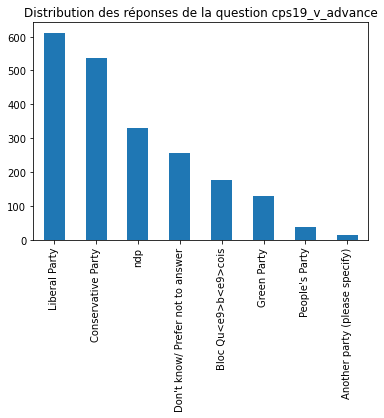

In [145]:
col_of_interest = "cps19_v_advance"
print(df[col_of_interest].value_counts())
plot_column_values(col_of_interest)

### Isoler les questions "étiquette"

In [140]:
label_questions = ['cps19_votechoice', 'cps19_votechoice_pr', 'cps19_vote_unlikely', 'cps19_vote_unlike_pr', 'cps19_v_advance']
label_detail_questions = ['cps19_votechoice_7_TEXT', 'cps19_votechoice_pr_7_TEXT', 'cps19_vote_unlikely_7_TEXT', 'cps19_vote_unlike_pr_7_TEXT', 'cps19_v_advance_7_TEXT', 'cps19_vote_lean', 'cps19_vote_lean_7_TEXT', 'cps19_vote_lean_pr', 'cps19_vote_lean_pr_7_TEXT', 'cps19_2nd_choice', 'cps19_2nd_choice_7_TEXT', 'cps19_2nd_choice_pr', 'cps19_2nd_choice_pr_7_TEXT', 'cps19_not_vote_for_1', 'cps19_not_vote_for_2', 'cps19_not_vote_for_3', 'cps19_not_vote_for_4', 'cps19_not_vote_for_5', 'cps19_not_vote_for_6', 'cps19_not_vote_for_7', 'cps19_not_vote_for_8', 'cps19_not_vote_for_9', 'cps19_not_vote_for_7_TEXT']